<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/main/Single_Asset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Sample Paths

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [ ]:
def SimPaths(S0, kappa, theta, sigma, T, Ndt, Nsims):
    
    # time grid
    t = np.linspace(0, T, Ndt+1)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)

    # effective vol for large time steps
    #   sigma_eff = sigma *sqrt( (1-exp(-2*kappa*dt)) / (2*kappa) )
    #             ~ sigma *sqrt(  ( 1 - (1-2*kappa*dt + ..) ) /(2 *kappa) )
    #             ~ sigma *sqrt(  dt )
    sigma_eff = sigma * np.sqrt( (1-np.exp(-2*kappa*dt)) / (2*kappa))

    # store the sample paths
    X = np.zeros((Nsims, Ndt+1))
    Y = np.zeros((Nsims, Ndt+1))
    Z = np.zeros((Nsims, Ndt+1))

    X[:,0] = S0[0]
    Y[:,0] = S0[1]
    Z[:,0] = S0[2]


    for i in range(Ndt):

#         # Euler discretization of the SDE
#         #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
#         dW_x = sqrt_dt * np.random.randn(Nsims)
#         X[:,i+1] = X[:,i]  + kappa[0] * (theta[0] - X[:,i]) * dt + sigma[0] * dW_x

#         # Euler discretization of the SDE
#         #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
#         dW_y = sqrt_dt * np.random.randn(Nsims)
#         Y[:,i+1] = Y[:,i] + kappa[1] * (theta[1] - Y[:,i]) * dt + sigma[1] * dW_y

        # Exact solution to the SDE
        #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
        N_x =  np.random.randn(Nsims)
        X[:,i+1] = theta[0] + (X[:,i]-theta[0])*np.exp(-kappa[0]*dt) + sigma_eff[0] * N_x
        
        # Euler discretization of the SDE
        #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
        N_y = np.random.randn(Nsims)
        Y[:,i+1] = theta[1] + (Y[:,i]-theta[1])*np.exp(-kappa[1]*dt) + sigma_eff[1] * N_y

        # update Z according to no-arbitrage
        Z[:,i+1] = 1.0/(X[:,i+1]*Y[:,i+1])
        
    return t, X, Y, Z

In [ ]:
# model paramteres on hourly time scales
kappa = np.array([2, 2])
theta = np.array([1, 1.1])
sigma = np.array([1, 1])*1e-3

# initial values of the FX rates
X0 = 1.000
Y0 = 1.1 #1.0995
Z0 = 1.0/(X0*Y0)

T = 1 # in minutes
Ndt = 600 # in miliseconds

Nsims = 150 # number of sims

t, X, Y, Z = SimPaths([X0, Y0, Z0], kappa, theta, sigma, T, Ndt, Nsims)

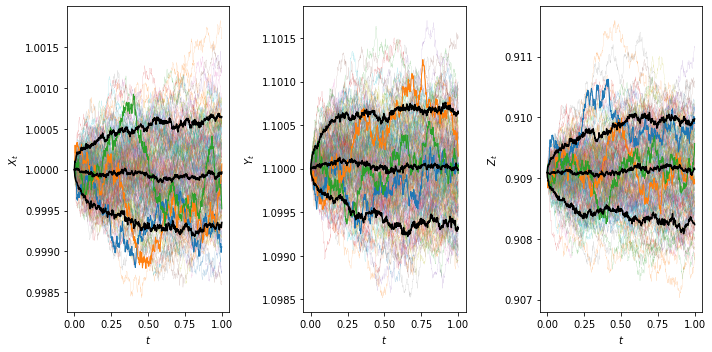

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, X.T, linewidth=0.1)
plt.plot(t, X[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(X,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$X_t$')

plt.subplot(1,3,2)
plt.plot(t, Y.T, linewidth=0.1)
plt.plot(t, Y[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Y,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Y_t$')

plt.subplot(1,3,3)
plt.plot(t, Z.T, linewidth=0.1)
plt.plot(t, Z[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Z,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Z_t$')

fig.tight_layout()

plt.show()

In [ ]:
import pandas as pd
data = {'Time': t, 
        'X': X[0],
        'Y' : Y[0],
        'Z': Z[0]}
  
# Convert the dictionary into DataFrame 
data = pd.DataFrame(data) 
print(data)

In [ ]:
# train_test_split = 0.5
# train = data[:int(train_test_split*len(data))]
# test = data[int(train_test_split*len(data)):]

In [ ]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [ ]:
env = Environment1(train)

In [ ]:
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [ ]:
hidden_size=100
input_size= 91
output_size=3
USE_CUDA = False
LR = 0.001

In [ ]:
Q = Q_Network(input_size, hidden_size, output_size)

In [ ]:
Q_ast = copy.deepcopy(Q)


In [ ]:
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

In [ ]:
#epoch_num = 20
memory_size = 200
batch_size = 50
gamma = 0.97

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 400
train_freq = 2
update_q_freq = 20
gamma = 0.97
show_log_freq = 5


In [ ]:
master_reward = []
#start = time.time()
for epoch in range(len(X[:100])):
    epoch_data = {'Time': t, 
        'X': X[epoch]}
    epoch_data = pd.DataFrame(epoch_data) 
    env = Environment1(epoch_data)
    step_max = len(env.data)-1
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)
        #print("action is: ", pact, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        master_reward.append(total_rewards)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

In [ ]:
print(len(total_rewards[:-600]))

59400


Text(0, 0.5, '$Rewards$')

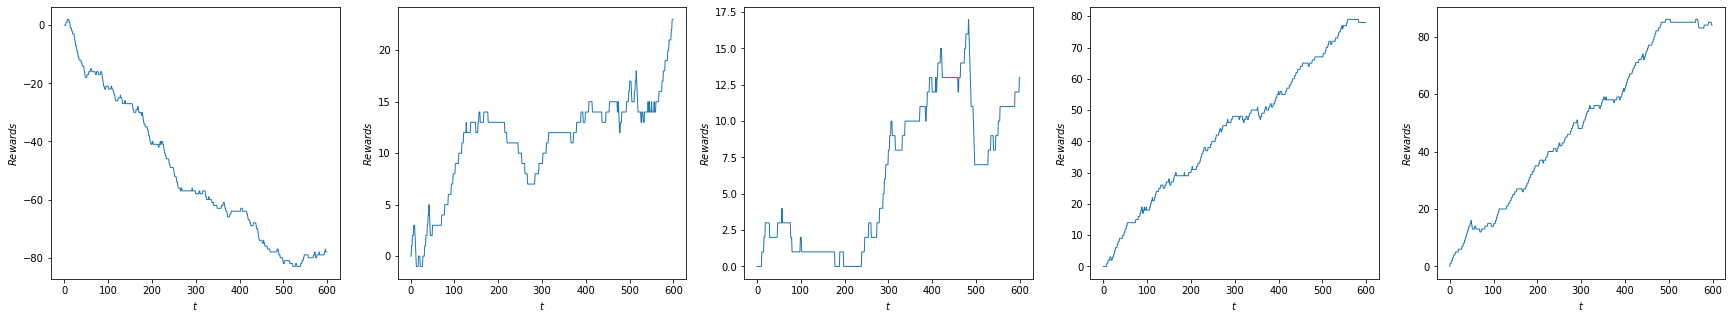

In [ ]:
t_in_ms = [i for i in range(len(total_rewards[59400:]))]
fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.plot(t_in_ms, total_rewards[600:1200], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,2)
plt.plot(t_in_ms, total_rewards[9600:10200], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,3)
plt.plot(t_in_ms, total_rewards[19200:19800], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,4)
plt.plot(t_in_ms, total_rewards[30000:30600], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,5)
plt.plot(t_in_ms, total_rewards[59400:], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')

Text(0, 0.5, 'Losses')

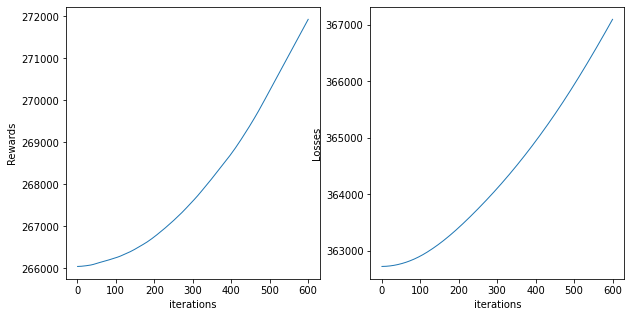

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(iterations, log_rewards, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Rewards')
plt.subplot(1,2,2)
plt.plot(iterations, log_losses, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Losses')

In [ ]:
print(len(log_rewards))
incremental_reward = []
for i in range(len(log_rewards)):
  if i>=1:
    incremental_reward.append((log_rewards[i]-log_rewards[i-1])/memory_size)


Text(0, 0.5, 'incremental_reward')

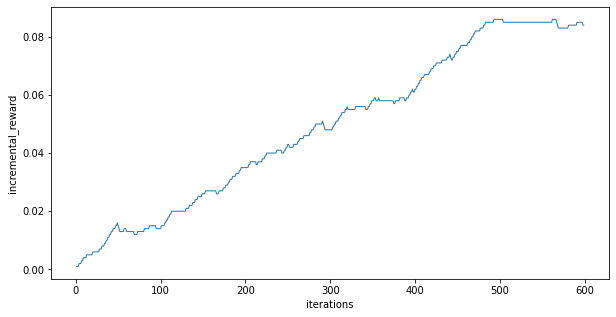

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(iterations[:-1], incremental_reward, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('incremental_reward')

In [ ]:
test_data = {'Time': t, 
        'X': X[101]}
test_data = pd.DataFrame(test_data) 
test_env = Environment1(test_data)

In [ ]:
#test_env = Environment1(X[100])
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
    #print(pact.numpy())        
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits

In [ ]:
t_in_ms = [i for i in range(len(test_rewards))]
plt.plot(t_in_ms, test_rewards, linewidth=1)

In [ ]:
print(test_profits)

0.003294400282105925


In [ ]:
#Try all sample path
samplepath_number = []
test_profits = []
for i in range(101,len(X)):
  test_data = {'Time': t, 
        'X': X[i]}
  # Convert the dictionary into DataFrame 
  test_data = pd.DataFrame(test_data) 
  test_env = Environment1(test_data)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []
  print("Percentage done: ", i*100/len(X))
  for _ in range(len(test_env.data)-1):
      
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      obs, reward, done = test_env.step(pact.numpy())
      test_rewards.append(reward)

      pobs = obs
          
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)




(array([1., 1., 3., 0., 2., 5., 0., 2., 2., 6., 6., 4., 3., 4., 1., 2., 2.,
        4., 0., 1.]),
 array([-0.00455921, -0.00403906, -0.0035189 , -0.00299875, -0.00247859,
        -0.00195844, -0.00143828, -0.00091813, -0.00039798,  0.00012218,
         0.00064233,  0.00116249,  0.00168264,  0.0022028 ,  0.00272295,
         0.0032431 ,  0.00376326,  0.00428341,  0.00480357,  0.00532372,
         0.00584388]),
 <a list of 20 Patch objects>)

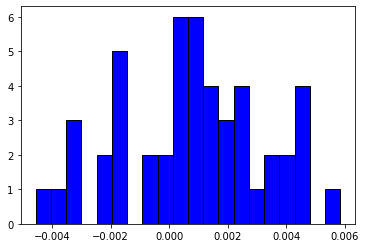

In [ ]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 20)

In [ ]:
YEAH = 0
NOOOO = 0
for elem in test_profits:
  if elem >= 0.0:
    YEAH += 1
  else:
    NOOOO -= 1

print("Percentage of Profitting: ", YEAH*100/(len(test_profits)),"%")

Percentage of Profitting:  69.38775510204081 %
